# Benchmarking more featurizations and ML methods in predicting formation enthalpies of compounds on OQMD dataset 

In this notebook, we'll compare performance of both featurizations and ML algorithms in [Ward (2016)](https://www.nature.com/articles/npjcompumats201628), [Ward (2017)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104), [Deml (2016)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.93.085142), [Faber (2016)](https://arxiv.org/abs/1503.07406) and [Schutt (2014)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118) in predicting formation enthalpies of compounds, $\Delta H_f$.

Note: Run `1_build-dataset.ipynb` before this notebook!

This notebook takes around 3 CPU hours to run. 

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import pymatgen as pmg
import matplotlib.pyplot as plt
import pickle
import time
import warnings

from matminer.featurizers.structure import SineCoulombMatrix
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.utils.conversions import str_to_composition

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import Lars

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88

/home/amoffet2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



Import OQMD_ICSD data

In [2]:
y = pd.read_pickle('./y.pkl')

In [3]:
print ("Length of data: ", y.shape)

Length of data:  (31163,)


Initialize dictionary to store cv prediction data

In [4]:
kernels = ['ward2016', 'ward2017', 'deml', 'faber', 'schutt']
cv_test = dict.fromkeys(kernels)
x_train, x_test, y_train, y_test = dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels), dict.fromkeys(kernels)

## 1) Faber et al (2016)
Kernel Ridge Regression (KRR) on Sine Coulomb Matrix (SCM) featurization. Since we already have the Coulomb matrix featurized file saved in `01.ipynb`, we can directly load it here.

In [5]:
%%time
X_faber = pickle.load(open("./X_faber.pkl", "rb"))

CPU times: user 24 ms, sys: 106 ms, total: 130 ms
Wall time: 593 ms


Partition into training and testing set (80% training and 20% testing)

In [6]:
x_train['faber'], x_test['faber'], y_train['faber'], y_test['faber'] = train_test_split(X_faber, y, test_size=0.2, shuffle=True)

#### Build ML model (Kernel Ridge Regression)

In [7]:
faber = KernelRidge(kernel='laplacian', alpha=1e-05, gamma=5e-05)

Train KRR model using training set data

In [8]:
%%time
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    faber.fit(x_train['faber'], y_train['faber'])

CPU times: user 8min 41s, sys: 3min 51s, total: 12min 33s
Wall time: 3min 3s


Prediction data

In [9]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_test['faber'] = cross_val_predict(faber, x_test['faber'], y_test['faber'], cv=KFold(n_splits=5))

## 2) Ward et al (2016)  
RandomForestRegressor on "general purpose" attributes  

In [10]:
X_ward2016 = pd.read_pickle("./X_ward2016.pkl")

In [12]:
x_train['ward2016'], x_test['ward2016'], y_train['ward2016'], y_test['ward2016'] = train_test_split(X_ward2016, y_ward2016, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor)

In [13]:
param = dict(max_features=(np.linspace(0.1, 1, 10)).tolist())
ward2016 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                        param_grid=param,
                        scoring='neg_mean_squared_error',
                        cv=KFold(5))

Fit using training set

In [14]:
%%time
ward2016 = ward2016.fit(x_train['ward2016'], y_train['ward2016'])

CPU times: user 30min, sys: 792 ms, total: 30min 1s
Wall time: 30min


Save the best model

In [15]:
ward2016 = ward2016.best_estimator_

Predict testing data using model

In [16]:
cv_test['ward2016'] = cross_val_predict(ward2016, x_test['ward2016'], y_test['ward2016'], cv=KFold(n_splits=5))

## 3) Ward et al (2017)

Random Forest Regressor on Voronoi-tessellation-based crystal representation.

Since the featurization takes a long time, we import the featurized pickle file ready for processing

In [17]:
X_ward2017 = pd.read_pickle('./X_ward2017.pkl')

Splitting dataset into training and testing data

In [18]:
x_train['ward2017'], x_test['ward2017'], y_train['ward2017'], y_test['ward2017'] = train_test_split(X_ward2017, y, test_size=0.2, shuffle=True)

#### Build ML model (Random Forest Regressor) 

In [19]:
param = dict(max_features=(np.linspace(0.1, 1, 10)).tolist())
ward2017 = GridSearchCV(RandomForestRegressor(n_estimators=100),
                        param_grid=param,
                        scoring='neg_mean_squared_error',
                        cv=KFold(5))

In [20]:
%%time 
ward2017 = ward2017.fit(x_train['ward2017'], y_train['ward2017'])

CPU times: user 2h 17min 43s, sys: 2.3 s, total: 2h 17min 45s
Wall time: 2h 17min 42s


In [21]:
cv_test['ward2017'] = cross_val_predict(ward2017, x_test['ward2017'], y_test['ward2017'], cv=KFold(n_splits=5))

## 4) Deml et al
Stepwise linear regression on composition featurized data. Since featurized data is already saved from running `featurize_deml_dataset.ipynb`, we can load data directly from that. 

In [22]:
df_deml = pd.read_pickle('./X_deml.pkl')

Remove outliers

In [23]:
original_count = len(df_deml)
df_deml = df_deml[np.logical_and(df_deml['delta_e'] >= -20, df_deml['delta_e'] <= 5)].reset_index(drop=True)
print('Removed %d/%d entries'%(original_count - len(df_deml), original_count))

Removed 4/36047 entries


Fill NaN with zero values

In [24]:
df_deml.fillna(value=0, inplace=True)

In [25]:
X_deml = df_deml.drop(['oxidation_states', 'total_energy', 'delta_e', 'composition', 'composition_obj'], 1)
y_deml = df_deml['delta_e']

Partition data into training and testing set

In [26]:
x_train['deml'], x_test['deml'], y_train['deml'], y_test['deml'] = train_test_split(X_deml, y_deml, test_size=0.2, shuffle=True)

#### Build ML model (Stepwise Linear Regression)

In [27]:
deml = GridSearchCV(Lars(), 
                    param_grid=dict(n_nonzero_coefs=(range(10, X_deml.shape[1], 20))),
                    cv=KFold(5))

In [28]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    deml = deml.fit(x_train['deml'], y_train['deml'])

CPU times: user 17min 56s, sys: 45min 27s, total: 1h 3min 23s
Wall time: 4min 10s


Save the best model

In [29]:
deml = deml.best_estimator_

Predict testing data

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_test['deml'] = cross_val_predict(deml, x_test['deml'], y_test['deml'], cv=KFold(5))

## 5) Schutt et al
Kernel Ridge Regression on Partial Radial Distribution Function (PRDF) representation.

In [31]:
X_schutt = pd.read_pickle("./X_schutt.pkl")

Partition data into training and testing set

In [32]:
x_train['schutt'], x_test['schutt'], y_train['schutt'], y_test['schutt'] = train_test_split(X_schutt, y, test_size=0.2, shuffle=True)

#### Build ML model (Kernel Ridge Regression)

In [33]:
schutt = KernelRidge(kernel='laplacian', alpha=0.001, gamma=5e-5)

In [34]:
%%time
schutt = schutt.fit(x_train['schutt'], y_train['schutt'])

CPU times: user 4h 25min 51s, sys: 5min 59s, total: 4h 31min 51s
Wall time: 4h 24min 14s


Predict testing data

In [35]:
cv_test['schutt'] = cross_val_predict(schutt, x_test['schutt'], y_test['schutt'], cv=KFold(5))

## Now we compare these five models 

In [36]:
stats = dict.fromkeys(kernels)
for kernel in stats:
    stats[kernel] = dict.fromkeys(['r2_score', 'mean_absolute_error', 'mean_squared_error'], 0.0)

In [37]:
for kernel in kernels:
    for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
        stats[kernel][scorer] = (getattr(metrics,scorer)(y_test[kernel], cv_test[kernel]))

Plot predictions

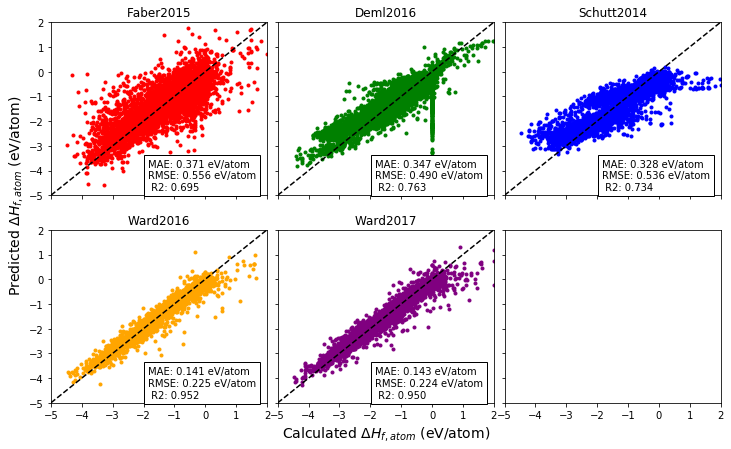

In [38]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

ax[0,0].set_xlim([-5, 2])
ax[0,0].set_ylim([-5, 2])

ax[0,0].set_ylabel("Predicted $\Delta H_{f, atom}$ (eV/atom)", fontsize=14, y=0.0)
ax[1,1].set_xlabel("Calculated $\Delta H_{f, atom}$ (eV/atom)", fontsize=14)

ax[0,0].set_title("Faber2015")
ax[0,1].set_title("Deml2016")
ax[0,2].set_title("Schutt2014")
ax[1,0].set_title("Ward2016")
ax[1,1].set_title("Ward2017")

ax[0,0].scatter(y_test['faber'], cv_test['faber'], marker='.', color='r')
ax[0,1].scatter(y_test['deml'], cv_test['deml'], marker='.', color='g')
ax[0,2].scatter(y_test['schutt'], cv_test['schutt'], marker='.', color='b')
ax[1,0].scatter(y_test['ward2016'], cv_test['ward2016'], marker='.', color='orange')
ax[1,1].scatter(y_test['ward2017'], cv_test['ward2017'], marker='.', color='purple')

for i in range(2):
    for j in range(3):
        if (i==1 and j==2):
            pass
        else:
            ax[i,j].plot(ax[i,j].get_xlim(), ax[i,j].get_xlim(), 'k--')

ax[0,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['faber']['mean_absolute_error'], np.sqrt(stats['faber']['mean_squared_error']), stats['faber']['r2_score']),
        transform=ax[0,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['deml']['mean_absolute_error'], np.sqrt(stats['deml']['mean_squared_error']), stats['deml']['r2_score']),
        transform=ax[0,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[0,2].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['schutt']['mean_absolute_error'], np.sqrt(stats['schutt']['mean_squared_error']), stats['schutt']['r2_score']),
        transform=ax[0,2].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,0].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2016']['mean_absolute_error'], np.sqrt(stats['ward2016']['mean_squared_error']), stats['ward2016']['r2_score']),
        transform=ax[1,0].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax[1,1].text(0.45, 0.03, 'MAE: {:.3f} eV/atom\nRMSE: {:.3f} eV/atom\n R2: {:.3f}'.format(stats['ward2017']['mean_absolute_error'], np.sqrt(stats['ward2017']['mean_squared_error']), stats['ward2017']['r2_score']),
        transform=ax[1,1].transAxes, fontsize=10,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.set_size_inches((12, 7))
fig.subplots_adjust(wspace=0.05)

Findings: Composition based features used in Ward 2016 paper seems to predict formation enthalpy best, and the training time is reasonably short as compared to Faber2015 and Schutt2014's methods. 